In [1]:
import pickle5 as pickle
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import random

import plotly.express as px

import eval
import utils as ut
import plot

pd.options.mode.chained_assignment = None # turns off pandas SettingWithCopyWarning

### Run parameters

In [2]:
plot_individual_results = False
#score_column = 'coefficient'
kthresh = 10
score_column = f'top{kthresh} path score'
path_column = 'path category'
category_column = 'category'
k_range = list(range(1, 11))
limit_k = True
figure_dir = '../../figures/'

### Load benchmark and results

In [3]:
# load benchmark
with open('../../data/commonsense_benchmark/v4/commonsense_benchmark_one_sibling.json', 'r') as f:
    benchmark = json.load(f)
    
print(f'Loaded benchmark with {len(benchmark)} triples')

Loaded benchmark with 895 triples


In [4]:
# load explanations
results_dir = '../../explanations/linklogic/full_parents_benchmark/'
experiments = {'sibling false, child true': ['fb13', 'True'],
              'sibling false, child false': ['fb13', 'False'],
              'sibling true, child true': ['fb14', 'True'],
              'sibling true, child false': ['fb14', 'False']}

In [5]:
results = dict()
for experiment, strings in experiments.items():
    print(f'Loading results for experiment {experiment}')
    sibling = strings[0]
    child = strings[1]
    with open(f'{results_dir}/{sibling}_child_{child}.pickle', 'rb') as f:
        results[experiment] = pickle.load(f)

Loading results for experiment sibling false, child true
Loading results for experiment sibling false, child false
Loading results for experiment sibling true, child true
Loading results for experiment sibling true, child false


### Compute Metrics

In [6]:
import eval
metrics = []
feature_df_list = []

for i, bmk in tqdm(enumerate(benchmark), total=len(benchmark)):

    assert bmk['category'] == 'parents'
    assert len(bmk['entity_names']['siblings']) == 1

    triple = bmk['query_triple']
    s_triple = ut.stringify_path(triple)

    bmk_df = eval.extract_bmk_paths_as_df(bmk, ctg_column=category_column)

    for experiment in experiments.keys():

        res = eval.get_results_for_query_triple(results[experiment], triple)
        if not res:
            continue
            
        feature_df = eval.extract_feature_df_from_results(res['linklogic_features'], bmk_df=bmk_df, names=bmk['entity_names'], kthresh=kthresh,
                                                          experiment=experiment, query_triple=s_triple)
        num_true_candidates = feature_df['label'].sum()
        if num_true_candidates == 0:
            continue

        feature_df_list.append(feature_df)
        
        y_true = [feature_df['label']]
        y_true_weighted = [feature_df['bmk confidence']]
        y_heuristic = [feature_df['baseline path score']]
        y_linklogic = [feature_df['coefficient']]
        y_random = [feature_df['random']]
        
        if limit_k:
            ks = eval.filter_k_range(k_range, feature_df['coefficient'])
        else:
            ks = k_range

        metrics.append({'experiment': experiment,
                        'ndcg: heuristic': eval.ndcg_score_range(y_true, y_heuristic, ks),
                        'ndcg: linklogic': eval.ndcg_score_range(y_true, y_linklogic, ks),
                        'ndcg: random': eval.ndcg_score_range(y_true, y_random, ks),
                        
                        'wndcg: heuristic': eval.ndcg_score_range(y_true_weighted, y_heuristic, ks),
                        'wndcg: linklogic': eval.ndcg_score_range(y_true_weighted, y_linklogic, ks),
                        'wndcg: random': eval.ndcg_score_range(y_true_weighted, y_random, ks),
                        
                        'p@k: heuristic': eval.precision_at_k_range(y_true[0], y_heuristic[0], ks),
                        'p@k: linklogic': eval.precision_at_k_range(y_true[0], y_linklogic[0], ks),
                        'p@k: random': eval.precision_at_k_range(y_true[0], y_random[0], ks),
            
                        'num true': num_true_candidates,
                        'query triple': s_triple,
                        'kge score': float(res['query_triple_kge_score']),
                        'fidelity': res['linklogic_metrics']['test_acc']})

        if plot_individual_results:
            fig = px.scatter(feature_df, x='baseline path score', y='coefficient', color='label',
                             hover_data=["path"], title=f'features: {s_triple}')
            fig.show()

100%|██████████| 895/895 [02:24<00:00,  6.17it/s]


In [8]:
fdata = pd.concat(feature_df_list, axis=0)
xcol = 'coefficient'
min_count = 5
palette = {'sibling false, child false':'tab:red',
 'sibling false, child true': 'tab:olive',
 'sibling true, child false': 'mediumorchid',
 'sibling true, child true': 'tab:cyan'}

query_triples = random.sample(set(fdata.query_triple), 5)

# for experiment in experiments.keys():
    
#     plot.incidents_per_path_category(fdata, experiments=[experiment], min_count=min_count, palette=palette, score_column='coefficient', 
#                                      path_column=path_column, filename=f'{figure_dir}/linklogic: {experiment}.png')

#     plot.incidents_per_path_category(fdata, experiments=[experiment], min_count=min_count, palette=palette, score_column=f'top{kthresh} path score', 
#                                      path_column=path_column, filename=f'{figure_dir}/Heuristic: {experiment}.png')
    
    
   # for triple in query_triples:
   #     plot.scores_per_path_category(fdata, score_column='normalized coefficient', title=f'Path Logic {triple}', experiments=[experiment],
   #                                   filename=f'{figure_dir}linklogic scores {experiment} {triple}.png', min_val = 0.01, palette=palette, query_triple=triple)

   #     plot.scores_per_path_category(fdata, score_column=f'top{kthresh} path score', title=f'Heuristic Scoring, top {kthresh}, {triple}', experiments=[experiment],
   #                                   filename=f'{figure_dir}Heuristic scores {experiment} {triple}.png', min_val=0.1, palette=palette, query_triple=triple)

# plot.incidents_per_path_category(fdata, experiments=['sibling false, child true', 'sibling false, child false'], min_count=min_count,
#                                  palette=palette, score_column=score_column, path_column=path_column, filename=f'{figure_dir}Exp1_2_NoSibling_RemoveChild.png')
# plot.incidents_per_path_category(fdata, experiments=['sibling true, child true', 'sibling true, child false'], min_count=min_count,
#                                  palette=palette, score_column=score_column, path_column=path_column, filename=f'{figure_dir}Exp3_WithSibling_RemoveChild.png')
# plot.incidents_per_path_category(fdata, experiments=['sibling false, child false', 'sibling true, child false'], min_count=min_count,
#                                  palette=palette, score_column=score_column, path_column=path_column, filename=f'{figure_dir}Exp2_3_NoChild_AddSibling.png')
# plot.incidents_per_path_category(fdata, experiments=['sibling false, child true', 'sibling true, child true'], min_count=min_count,
#                                  palette=palette, score_column=score_column, path_column=path_column, filename=f'{figure_dir}Exp1_3_WithChild_AddSibling.png')

In [9]:
pivot_fdata = fdata.pivot(index=['query_triple', 'path', 'path category'], columns='experiment', values='coefficient')

In [12]:
pivot_fdata.reset_index(inplace=True)
pivot_fdata.head()

experiment,query_triple,path,path category,"sibling false, child false","sibling false, child true","sibling true, child false","sibling true, child true"
0,abigail_may_alcott_nieriker--parents--abby_may,abby_may--cause_of_death--cancer,P--cause_of_death--X,NaN,NaN,0.0,0.000000
1,abigail_may_alcott_nieriker--parents--abby_may,abby_may--cause_of_death--pancreatic_cancer,P--cause_of_death--X,NaN,NaN,0.0,0.000000
2,abigail_may_alcott_nieriker--parents--abby_may,abby_may--children--abigail_may_alcott_nieriker,**P--has_child->C,NaN,1.042151,NaN,0.875528
3,abigail_may_alcott_nieriker--parents--abby_may,abby_may--children--ahmed_iii,P--has_child->X,NaN,NaN,0.0,0.000000
4,abigail_may_alcott_nieriker--parents--abby_may,abby_may--children--ahmed_iii--sibling--abigai...,C--sibling--X--has_parent->P,NaN,NaN,0.0,0.000000


In [13]:
pivot_fdata['difference'] =  pivot_fdata['sibling true, child false'] - pivot_fdata['sibling false, child false']

In [16]:
pivot_fdata.head()

experiment,query_triple,path,path category,"sibling false, child false","sibling false, child true","sibling true, child false","sibling true, child true",difference
0,abigail_may_alcott_nieriker--parents--abby_may,abby_may--cause_of_death--cancer,P--cause_of_death--X,NaN,NaN,0.0,0.000000,NaN
1,abigail_may_alcott_nieriker--parents--abby_may,abby_may--cause_of_death--pancreatic_cancer,P--cause_of_death--X,NaN,NaN,0.0,0.000000,NaN
2,abigail_may_alcott_nieriker--parents--abby_may,abby_may--children--abigail_may_alcott_nieriker,**P--has_child->C,NaN,1.042151,NaN,0.875528,NaN
3,abigail_may_alcott_nieriker--parents--abby_may,abby_may--children--ahmed_iii,P--has_child->X,NaN,NaN,0.0,0.000000,NaN
4,abigail_may_alcott_nieriker--parents--abby_may,abby_may--children--ahmed_iii--sibling--abigai...,C--sibling--X--has_parent->P,NaN,NaN,0.0,0.000000,NaN


No handles with labels found to put in legend.


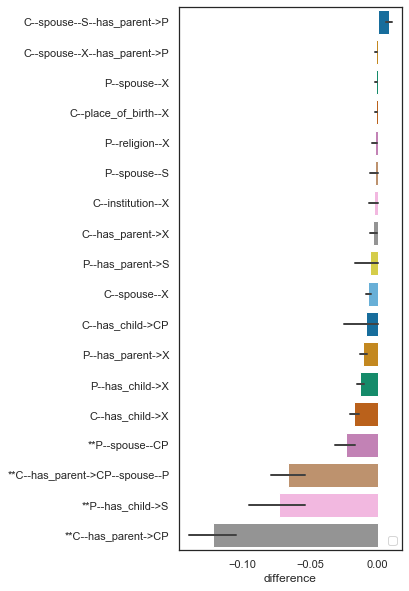

In [24]:
plot.scores_per_path_category(pivot_fdata, score_column='difference', min_val=0.001, abs_mean=True)

In [21]:
abs(pivot_fdata.groupby('path category')['difference'].mean())

path category
**C--has_parent->CP               0.121685
**C--has_parent->CP--spouse--P    0.065890
**C--sibling--S                        NaN
**C--sibling--S--has_parent->P         NaN
**P--has_child->C                      NaN
                                    ...   
P--sibling--S                          NaN
P--sibling--X                          NaN
P--spouse--C                      0.000215
P--spouse--S                      0.002213
P--spouse--X                      0.001216
Name: difference, Length: 87, dtype: float64

In [ ]:
# overlay = 'num true'
# M = pd.DataFrame(metrics)  

# plot.scatter_with_facets(M=M, x='wndcg: random', y='wndcg: linklogic', color=overlay, filename=None)
# plot.scatter_with_facets(M=M, x='wndcg: score heuristic', y='wndcg: linklogic', color=overlay, filename=None)
# plot.scatter_with_facets(M=M, x='wndcg: random', y='wndcg: score heuristic', color=overlay, filename=None)

### Summary metrics: NDCG

In [ ]:
M = pd.DataFrame(metrics)  

In [ ]:
from plotnine import *

In [ ]:
rows = []
metric = 'ndcg'
for i, row in M.iterrows():
    
    max_k = len(row[f'{metric}: random'])
    ks = k_range[:max_k]
        
    for k in ks:
        rows.append({
            'k': str(k),
            'query triple': row['query triple'],
            'experiment': row['experiment'],
            f'{metric}: heuristic': row[f'{metric}: heuristic'][k-1],
            f'{metric}: linklogic': row[f'{metric}: linklogic'][k-1],
            f'{metric}: random': row[f'{metric}: random'][k-1]
        })
m = pd.DataFrame(rows).melt(id_vars=['k', 'query triple', 'experiment'])

m = m[m['k'].isin(['1', '2', '3', '4', '5', '6', '7', '8', '9'])]
#px.box(m, x='k', y='value', color='variable', facet_col='experiment')
p = ggplot(m, aes(x='k', y='value', fill='variable')) + geom_boxplot() + facet_grid('.~experiment')
p.save(f'{metric}_at_k.png', height=5, width=15)